#Run first time only

In [1]:
#@title
#Install the PyDrive wrapper & import libraries.
!pip3 install pydub &> /dev/null
!apt install sox &> /dev/null
!pip3 install ffmpeg-python &> /dev/null
!pip3 install pickle5 &> /dev/null
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.io.wavfile import write

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# file_id = '1wWWsPgyI2I8X3x6FQSj8xRn1ksrsRw46'
file_id = '1taSXzAGep0SwWtn6p1q3ltJeMtBA3rt-'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

file_id = '1CJTK2POLCS7GC4J7BEnfrQ7qlwmJkM7v'
# file_id = '13Ka77s2uC3QDx8ahhyoBjCZxCxI3HdWq'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

!unzip -o /content/New_diffq_web.zip &> /dev/null
!rm /content/New_diffq_web.zip

!mv /content/checkpoint* /content/New_diffq_web/

%cd /content/New_diffq_web
# !python3 setup.py build_ext --inplace &> /dev/null

from demucs import Demucs
# from Diffq import DiffQuantiazer
# import pickle5 as pickle
import tensorflow as tf

def pred(model=None, noisy_path = "", model_path = ""):
		self_sample_rate = 16_000
		total_seconds_of_audio = 10
		total_number_of_sample = self_sample_rate * total_seconds_of_audio
		raw_audio_noisy = tf.io.read_file(noisy_path)
		noisy, sample_rate = tf.audio.decode_wav( raw_audio_noisy, desired_channels=1)
		number_of_total_sample = noisy.shape[0]
		number_of_chunks = (number_of_total_sample + total_number_of_sample - 1) // total_number_of_sample
		if isinstance(model, type(None)):
			model = Demucs(input_shape=(total_number_of_sample, 1))
			# global quantizer
			# quantizer = DiffQuantiazer(model)
			# with open(model_path, 'rb') as handle:
			# 	state = pickle.load(handle)

			# quantizer.restore_quantized_state(state)
			model.load_weights(model_path)
			# model = tf.keras.models.load_model(model_path, compile=False)
		number_of_total_sample_upperbound = number_of_chunks * total_number_of_sample
		padded_noisy = tf.pad(noisy, tf.constant([[0, number_of_total_sample_upperbound - number_of_total_sample], [0, 0]]), "CONSTANT")
		padded_noisy = tf.reshape(padded_noisy, [number_of_total_sample_upperbound // total_number_of_sample, total_number_of_sample, 1])
		# self.total_batch = number_of_total_sample_upperbound // total_number_of_sample
		# print(self.total_batch)
		# self.total_batch = (self.total_batch + self.batch_size - 1) // self.batch_size 
		# lamda_call = tf.keras.callbacks.LambdaCallback(on_predict_batch_end=self.upd)
		estimate = model.predict(padded_noisy, batch_size=1)
		estimate = tf.reshape(estimate, [number_of_total_sample_upperbound, 1])
		estimate = estimate[:number_of_total_sample,:]
		return noisy, estimate
		# match = self.noisy_path[self.noisy_path.find("fileid_") + 7:]
		# wavfile.write(self.enhanced_path + f"enhanced_{match}", 48000, tf.reshape(estimate,[-1]).numpy())
		# tf.io.write_file(self.enhanced_path, tf.audio.encode_wav(estimate, 48000))#))
		# tf.io.write_file(self.enhanced_path + f"enhanced_{match}", tf.audio.encode_wav(estimate, 48000))#))
		# tf.io.write_file(self.enhanced_path, tf.reshape(estimate,[-1]))

/content/New_diffq_web


#Run for each audio

##Upload audio here

In [7]:
from google.colab import files
%cd /content
uploaded = files.upload()

/content


Saving Jahaje .m4a to Jahaje .m4a


##Just run

In [8]:
#@title
import os
import glob
from pydub import AudioSegment
files = []
for file in glob.glob("/content/*.*"):
    files.append(file)
exten = os.path.splitext(files[0])[1][1:]
# print(exten)
if len(files) != 0:
  if exten != 'wav':
    sound = AudioSegment.from_file(files[0], exten)
    sound.export('/content/noisy.wav', format="wav")
  else:
    !mv /content/*.wav /content/noisy.wav
  # !apt install sox &> /dev/null
  !sox /content/noisy.wav -r 16000 /content/noisyf.wav 
  noisy, estimate = pred(noisy_path = "/content/noisyf.wav", model_path = "/content/New_diffq_web/checkpoint_epoch-085_loss-0.002397.h5")
  !cd /content/
  !rm /content/*.*
else:
  print("No audio found")
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display as ipd
from IPython.display import Audio

##Outputs

In [9]:
print("This is the noisy audio\n")
noisy = tf.reshape(noisy, [-1])
Audio(noisy.numpy(), rate=16000)

This is the noisy audio



In [10]:
print("This is the enhanced audio\n")
estimate = tf.reshape(estimate, [-1])
Audio(estimate.numpy(), rate=16000)

This is the enhanced audio



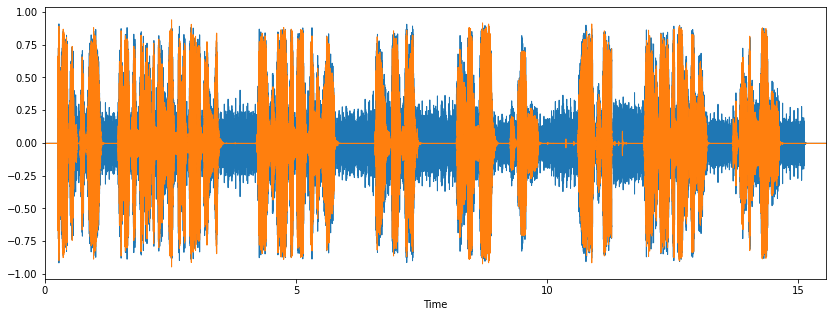

In [11]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(noisy.numpy(), sr=16000)
librosa.display.waveplot(estimate.numpy(), sr=16000)